In [1]:
#CHANGE THE PATH TO THE PATH AT YOUR PC!
path = "C:\\Users\\user\\Desktop\\TUe\\Topological\\Project\\Geolife Trajectories 1.3\\Data\\"
CITY_BORDERS = [40.19, 39.65, 115.98, 116.74]
#Optimal threshold for # of occurances per cell to be classified as a vetex - 600

import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

Idea: for every trajectory, compute the ordered list of vertices encountered. Pairs of subsequently-visited vertices will span the edges of the graph

In [2]:
df = pd.read_csv(".\\presets\\very_short.csv")
#[(f, b) for f, b in zip(range(6), range(5))] #just an example

In [3]:
df

,latitude,longitude,altitude,date,trajectory,user,transportation
0,39.994622,116.326757,150,2008-10-27 19:54:52,0.200810,0,NaN
1,39.994614,116.326751,150,2008-10-27 19:54:54,0.200810,0,NaN
2,39.994602,116.326769,150,2008-10-27 19:54:59,0.200810,0,NaN
3,39.994599,116.326769,150,2008-10-27 19:55:04,0.200810,0,NaN
4,39.994599,116.326769,150,2008-10-27 19:55:07,0.200810,0,NaN
...,...,...,...,...,...,...,...
166955,39.986867,116.304267,65,2008-03-16 10:12:08,99.200803,99,NaN
166956,39.987133,116.305183,42,2008-03-16 10:13:19,99.200803,99,NaN
166957,39.987633,116.305267,90,2008-03-16 10:14:26,99.200803,99,NaN
166958,39.988183,116.306317,37,2008-03-16 10:16:10,99.200803,99,NaN


## This will be an attempt at the graphification - probably I won't do this in one go

In [4]:
class Cell():
    '''Just your regular Square kind of a class'''
    def __init__(self, top: float, left: float, bottom: float, right: float):
        self.top = top
        self.left = left
        self.bottom = bottom
        self.right = right
        self.number_of_locations = 0
        self.is_a_vertex = False
        
    def __str__(self):
        return "Cell: top = " + str(round(self.top, 5)) + ", left = " + str(round(self.left, 5)) + \
    ", bottom = " + str(round(self.bottom, 5)) + ", right = " + str(round(self.right, 5))

    def belongs(self, latitude: float, longitude: float):
        '''checks if a point belongs to the cell - pass the point as (y, x)'''
        return (latitude > self.bottom and latitude <= self.top and longitude < self.right and longitude >= self.left)
    
    def vertexize(self, threshold = 600):
        '''makes the Cell become a vertex if has more locations that threshold'''
        
        if self.number_of_locations > threshold:
            self.is_a_vertex = True

    

class Grid():
    '''pretty much just a list of Cells that is available at self.cell_list'''
    
    def __init__(self, latitude_cells_nr: int, longitude_cells_nr: int, city_borders = CITY_BORDERS):
        self.latitude_cells_nr = latitude_cells_nr
        self.longitude_cells_nr = longitude_cells_nr
        self.city_borders = city_borders
        
        self.latitude_cell_length = round((city_borders[0] - city_borders[1])/latitude_cells_nr, 5)
        self.longitude_cell_length = round((city_borders[3] - city_borders[2])/longitude_cells_nr, 5)
        
        self.cell_list = []
        for i in range(latitude_cells_nr):
            for j in range(longitude_cells_nr):
                self.cell_list.append(Cell(top=city_borders[1] + self.latitude_cell_length*i,
                                     left=city_borders[2] + self.longitude_cell_length*j,
                                     bottom=city_borders[1] + self.latitude_cell_length*(i+1),
                                     right=city_borders[2] + self.longitude_cell_length*(j+1)))
                
    def __str__(self):
        return "Grid of side length (latitude) " + str(self.latitude_cell_length) + \
    " and (longitude) " + str(self.longitude_cell_length) + " and total number of cells: " + \
    str(self.latitude_cells_nr*self.longitude_cells_nr)

        
    def feed_list_of_points(self, points: list):
        '''point is a tuple (y, x) - DO NOT MESS THE Y AND X UP!
        increase the number_of_locations for each cell, if the point belongs there'''
        
        for point in points:
            for cell in self.cell_list:
                if cell.belongs(point[0], point[1]):
                    cell.number_of_locations += 1
                    break
                    
                    
    def feed_list_of_cell_numbers(self, cell_numbers: list):
        '''for each cell number in the list, update the corresponding cell details'''
        
        for number in cell_numbers:
            self.cell_list[int(number)].number_of_locations += 1
            
    
    def vertexize(self, threshold):
        '''runs vertexize on each sell of the grid'''
        
        for cell in self.cell_list:
            cell.vertexize(threshold)

In [5]:
grid = Grid(30, 30) 
print(grid)

Grid of side length (latitude) 0.018 and (longitude) 0.02533 and total number of cells: 900


In [6]:
print(grid.cell_list[0].number_of_locations)

0


In [11]:
def latitude_to_row(latitude: float, latitude_cells_number: int, 
                    latitude_cell_length: float, CITY_BORDERS=CITY_BORDERS):
    '''For a given latitude in the row of a datafame, checks which row number in the grid the point belongs to'''
    
    for i in range(latitude_cells_number):
        if latitude < CITY_BORDERS[1] + i*latitude_cell_length: #we do not have to check the other containment!
            return i
    

def longitude_to_column(longitude: float, longitude_cells_number: int, 
                        longitude_cell_length: float, CITY_BORDERS=CITY_BORDERS):
    '''For a given longitude in the row of a datafame, checks which column number in the grid the point belongs to'''
    
    for i in range(longitude_cells_number):
        if longitude < CITY_BORDERS[2] + i*longitude_cell_length: #we do not have to check the other containment!
            return i
        

def row_column_to_cell_number(row_nr: int, column_nr: int, longitude_cells_nr: int):
    '''given the x and y in the grid, calculates the cell number'''
    
    return row_nr*longitude_cells_nr + column_nr
# lambda x,y,z: x*y+z

In [13]:
#This will perform some expensive computation. Around 7s on the 160k dataset

df['column_number'] = df['latitude'].apply(latitude_to_row, args=(grid.latitude_cells_nr, 
                                                                  grid.latitude_cell_length, CITY_BORDERS))

df['row_number'] = df['longitude'].apply(longitude_to_column, args=(grid.longitude_cells_nr, 
                                                                    grid.longitude_cell_length, CITY_BORDERS))

df['cell_number'] = df.apply(lambda x: row_column_to_cell_number(x['column_number'], x['row_number'],
                                                                 grid.longitude_cells_nr),axis = 1)


df = df.drop(['column_number', 'row_number'], axis=1).dropna(subset='cell_number').reset_index(drop=True)

In [14]:
df

,latitude,longitude,altitude,date,trajectory,user,transportation,cell_number
17973,39.894178,116.318200,-237,2008-03-28 22:54:40,10.200803,10,train,434.0
17974,39.894505,116.321132,-237,2008-03-28 22:55:14,10.200803,10,train,434.0
17975,39.894953,116.326452,-237,2008-03-28 22:56:13,10.200803,10,train,434.0
17976,39.894600,116.332542,-237,2008-03-28 22:57:12,10.200803,10,train,434.0
17977,39.889622,116.337040,-237,2008-03-28 22:58:11,10.200803,10,train,435.0
...,...,...,...,...,...,...,...,...
166669,39.991350,116.331000,18,2007-05-31 23:04:24,98.200705,98,train,584.0
166670,39.991383,116.331250,15,2007-05-31 23:04:36,98.200705,98,train,584.0
166671,39.991383,116.331433,7,2007-05-31 23:04:59,98.200705,98,train,584.0
166674,39.982367,116.327217,62,2007-05-31 23:27:52,98.200705,98,taxi,584.0


In [19]:
#This actually performs the large computation:
grid.feed_list_of_cell_numbers(list(df.cell_number))

#And this just switches some flags around:
grid.vertexize(THRESHOLD)

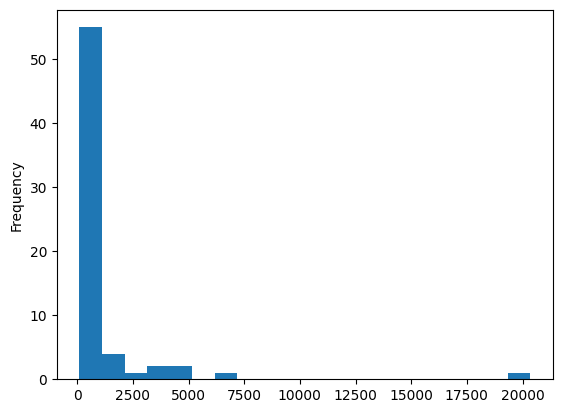

In [21]:
THRESHOLD = 100

def plot_cell_containment(grid: Grid, threshold: int, bins = 20):
    ''''''
    wow = pd.Series([grid.cell_list[i].number_of_locations for i in range(grid.latitude_cells_nr*grid.longitude_cells_nr)])
    wow = pd.Series([wow[i] for i in range(len(wow)) if wow[i] > threshold])
    wow.plot(kind='hist', bins=bins)
    
plot_cell_containment(grid, threshold=THRESHOLD)

In [ ]:
#     def feed_dataframe_of_points(self, df: pd.DataFrame):
#         '''point is a row with "latitude" as y and "longitude" as x - DO NOT MESS Y AND X UP!
#         increase the number_of_locations for each cell, if the point belongs there'''
        
#         #iterating over DataFrame's rows...unfortunately
#         for i in range(df.shape[0]):
            
#             #printing to see the progress:
#             if i % 25000 == 0:
#                 print(i)
                
#             for cell in self.cell_list:
#                 if cell.belongs(df.loc[i]["latitude"], df.loc[i]["longitude"]):
#                     cell.number_of_locations += 1
#                     break